In [9]:
!ls

Untitled.ipynb                kendalltaub.ipynb
acf_and_pacf.ipynb            kruskal_wallis.ipynb
adjusted_r_squared.ipynb      spurious_correlation.ipynb
cramer_v.ipynb                utils.py
ewa_and_bias_correction.ipynb


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence \
        import variance_inflation_factor

np.random.seed(47)
plt.style.use('dark_background')

n = 50
x1 = np.random.randint(10, 100, n)
x2 = np.random.randint(10, 100, n)
x3 = (
    0.8 * x1 + 0.2 * x2 + np.random.normal(0, 10)
).astype('int')

# True relationship for target variable y
y = 10 + 0.4 * x1 + 0.6 * x2 + np.random.randn()
data = pd.DataFrame(dict(x1=x1, x2=x2, x3=x3, y=y))
data.sample()

,x1,x2,x3,y
21,63,16,46,45.602587


<Figure size 900x1500 with 0 Axes>

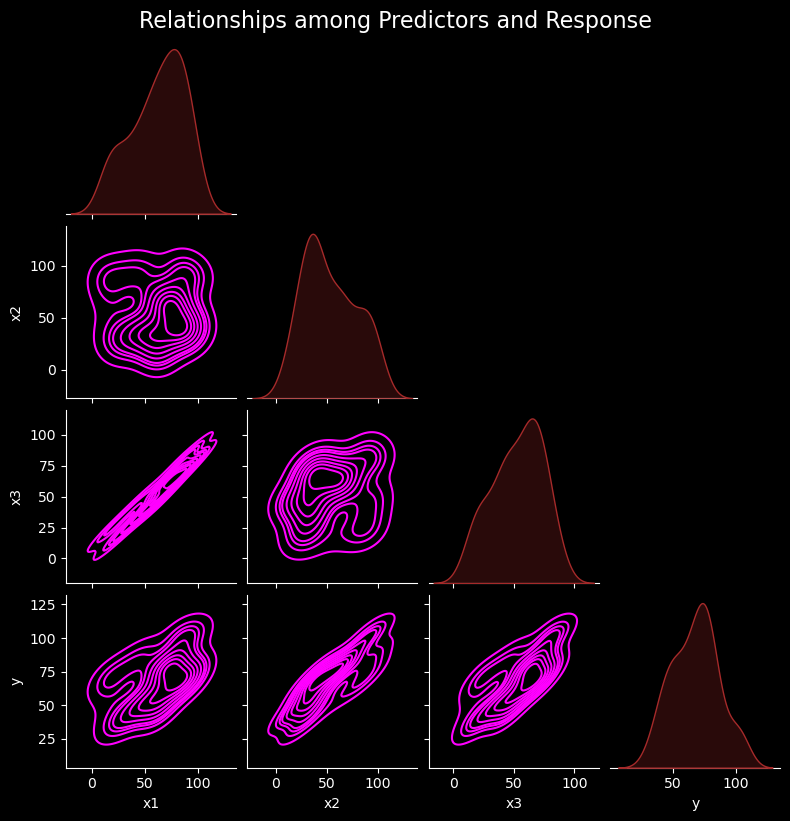

In [2]:
plt.figure(figsize=(3, 5), dpi=300)
pp = sns.pairplot(
    data, kind='kde', 
    height=2, corner=True, 
    diag_kws={'color': 'brown'}, 
    plot_kws={'color': 'magenta'}
)
plt.suptitle(
    "Relationships among Predictors and Response", 
    y=1.02, fontsize=16
)
plt.show()

### Condition Number ($\kappa(\mathbf{X})$)
  - $\kappa(\mathbf{X}) = \frac{\sigma_{\text{max}}}{\sigma_{\text{min}}}$
  - $\sigma_{\text{max}}$: Largest singular value of $\mathbf{X}$
  - $\sigma_{\text{min}}$: Smallest singular value of $\mathbf{X}$

- **Interpretation**:
  - **High $\kappa(\mathbf{X})$ (>30)**: Severe multicollinearity, near-singular matrix, unstable regression model.
  - **Low $\kappa(\mathbf{X})$ (~1)**: Well-conditioned matrix, less multicollinearity, stable model.

- **Use**: Measures how sensitive the solution is to small changes in input features.


In [3]:
X = data.drop('y', axis=1)
y = data['y']
CN = np.linalg.cond(X) 
print(f'The condition number of X is : {CN:.2f}')

The condition number of X is : 56.92


Since the condition number ($\kappa(\mathbf{X})$) of the matrix is greater than 30, it indicates **severe multicollinearity**.

The **Variance Inflation Factor (VIF)** of a feature  measures how much the variance of the estimated regression coefficient for that feature is inflated due to multicollinearity with other features.

**Formula for the $i$-th feature**
$$
VIF_i = \frac{1}{1 - R_i^2}
$$
Where $R_i^2$ is coefficient of determination when the $i$-th feature is regressed on all other features in the model.

**Interpretation**:
- $VIF_i > 10$: Indicates high multicollinearity
- $VIF_i \leq 10$: Indicates that the feature is not significantly collinear with others


In [4]:
def calc_vif(X):
    vif = pd.DataFrame(); vif["vars"] = X.columns
    vif["VIF"] = [
        variance_inflation_factor(X.values, i) 
        for i in range(X.shape[1])
    ]
    return vif

In [5]:
X = data.drop(['y'], axis=1)
vif_result = calc_vif(X)
vif_result

,variables,VIF
0,x1,479.841565
1,x2,18.466573
2,x3,634.845826


In [6]:
# Since VIF for x3 is the highest
# Let's drop it and recheck 
X = data.drop(['y', 'x3'], axis=1)
vif_result = calc_vif(X)
vif_result

,variables,VIF
0,x1,3.384752
1,x2,3.384752


In [7]:
# Now VIFs for both x1 and x2 is < 10; fit OLSE
X = X.assign(constant=1) 
model = sm.OLS(data['y'], X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 4.074e+30
Date:                Sat, 09 Nov 2024   Prob (F-statistic):               0.00
Time:                        22:51:28   Log-Likelihood:                 1467.8
No. Observations:                  50   AIC:                            -2930.
Df Residuals:                      47   BIC:                            -2924.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.4000   2.57e-16   1.56e+15      0.000       0.400       0.400
x2             0.6000   2.49e-16   2.41e+15      0.000       0.600       0.600
constant      10.8026   2.18e-14   4.95e+14      0.000      10.803      10.803
==============================================================================
Omnibus:                        3.574   Durbin-Watson:                   0.381
Prob(Omnibus):                  0.167   Jarque-Bera (JB):                3.157
Skew:                           0.526   Prob(JB):                        0.206
Kurtosis:                       2.362   Cond. No.                         296.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [8]:
# Visualize the condition number
plt.figure(figsize=(8, 6))
plt.bar(['Direct Method', 'Formula Method'], [condition_number_direct, condition_number_formula], color='skyblue')
plt.ylabel('Condition Number')
plt.title('Comparison of Condition Number Calculation Methods')
plt.show()

# Function to calculate VIF
def calc_vif(X):
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif

# Calculate VIF for the dataset
a

# Plot the VIF results
plt.figure(figsize=(8, 6))
sns.barplot(x='variables', y='VIF', data=vif_result, palette="viridis")
plt.ylabel('VIF')
plt.title('Variance Inflation Factor for Each Feature')
plt.xticks(rotation=45)
plt.show()

# Drop x3 (due to high VIF) and calculate VIF again
X = data.drop(['y', 'x3'], axis=1)
vif_result_dropped = calc_vif(X)

# Plot the VIF after dropping x3
plt.figure(figsize=(8, 6))
sns.barplot(x='variables', y='VIF', data=vif_result_dropped, palette="viridis")
plt.ylabel('VIF')
plt.title('VIF After Dropping x3')
plt.xticks(rotation=45)
plt.show()

# Fit an OLS model after dropping x3
X = X.assign(constant=1)  # For intercept term
model = sm.OLS(data['y'], X).fit()

# Show the summary of the model
print(model.summary())

NameError: name 'condition_number_direct' is not defined

<Figure size 800x600 with 0 Axes>